# Polish GameDev Stocks - Data Analysis Project

Tu napisać wstęp i cele projektu

### 1. Preparation of the environment

In [1]:
# Importing necessary libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import cvxpy as cp
import statsmodels.api as sm

%matplotlib inline

In [2]:
# loading stock price data of companies listed on the GPW. Source: stooq.pl
dfs = {}

for filename in os.listdir('data'):
    if filename.endswith('_d.csv'):
        ticker = filename.replace('_d.csv', '')
        dfs[ticker] = pd.read_csv(f'data/{filename}')

dfs['cdr'].tail()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
7677,2025-06-26,275.299911,276.699991,271.899573,275.6,158189.0
7678,2025-06-27,278.000000,278.600000,271.100000,275.3,168775.0
7679,2025-06-30,276.000000,286.600000,276.000000,280.8,301069.0
7680,2025-07-01,278.000000,282.400000,274.400000,276.0,166155.0
7681,2025-07-02,275.100000,275.700000,267.300000,269.8,197843.0


### 2. Data Exploration

In [3]:
print('Data shape: ', dfs['cdr'].shape)
print('Data types: \n', dfs['cdr'].dtypes)
print('\n', dfs['cdr'].columns)
print('\n Summary Statisctics:\n', dfs['cdr'].describe())

Data shape:  (7682, 6)
Data types: 
 Data           object
Otwarcie      float64
Najwyzszy     float64
Najnizszy     float64
Zamkniecie    float64
Wolumen       float64
dtype: object

 Index(['Data', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen'], dtype='object')

 Summary Statisctics:
           Otwarcie    Najwyzszy    Najnizszy   Zamkniecie       Wolumen
count  7682.000000  7682.000000  7682.000000  7682.000000  7.682000e+03
mean     62.894334    64.049839    61.678012    62.862732  2.895061e+05
std      86.563925    88.234317    84.836125    86.522136  5.199628e+05
min       0.649955     0.679950     0.629922     0.649955  0.000000e+00
25%       7.260044     7.419975     7.150012     7.301423  4.335140e+04
50%      18.924127    19.127487    18.792447    18.888125  1.453479e+05
75%      97.699156   100.411255    95.380676    97.997501  3.245811e+05
max     455.297513   464.196218   443.794747   460.802151  9.848691e+06


In [4]:
#Checking for null values in any dataframe
for ticker in dfs:
    if dfs[ticker].isnull().any().any() == True:
        print(dfs[ticker].isnull().sum())

In [5]:
# Changing date format
for ticker in dfs:
    dfs[ticker]['Data'] = pd.to_datetime(dfs[ticker]['Data'])

print(dfs['blo']['Data'].dtypes)

datetime64[ns]


In [6]:
# Changing column names from Polish to English language
for ticker in dfs:
    dfs[ticker] = dfs[ticker].rename(columns={
        'Data': 'Date',
        'Otwarcie': 'Open',
        'Najwyzszy': 'High',
        'Najnizszy': 'Low',
        'Zamkniecie': 'Close',
        'Wolumen': 'Volume'
    })

print(dfs['tsg'].columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


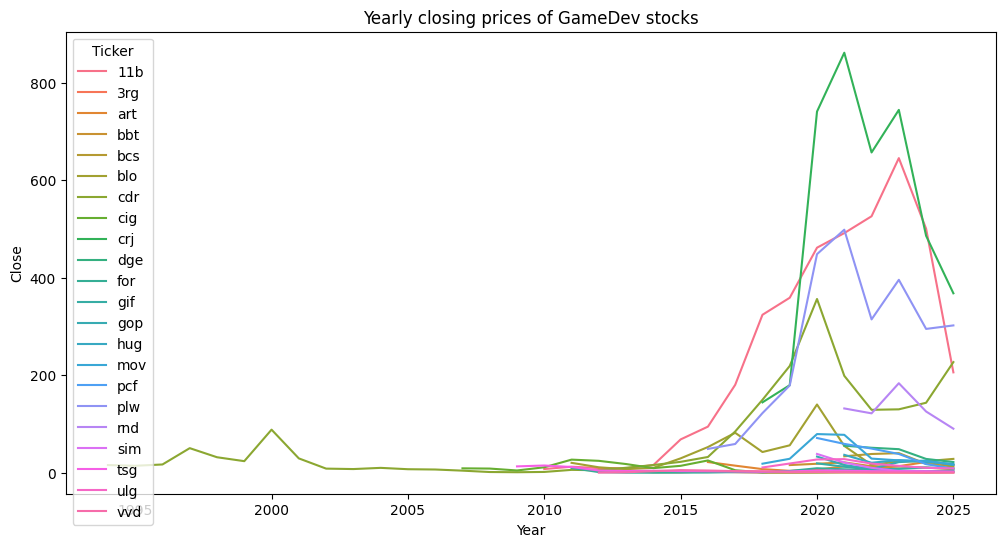

In [7]:
frames = []
for ticker in dfs:
    df = dfs[ticker].copy()
    df['Year'] = df['Date'].dt.year
    df_yearly = df.groupby('Year')['Close'].mean().reset_index()
    df_yearly['Ticker'] = ticker
    frames.append(df_yearly)

all_yearly = pd.concat(frames)

plt.figure(figsize=(12, 6))
sns.lineplot(data=all_yearly, x='Year', y='Close', hue='Ticker')
plt.title('Yearly closing prices of GameDev stocks')
plt.show()

### 3. Rolling correlation between CD Projekt Red vs other GameDev companies

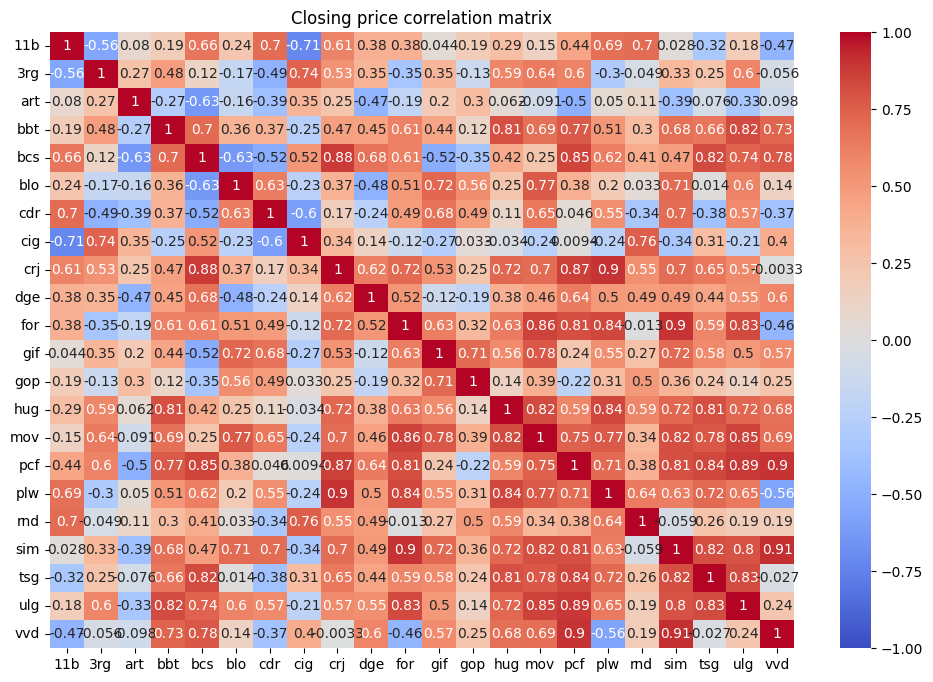

In [8]:
close_prices = pd.DataFrame()

for ticker in dfs:
    df = dfs[ticker][['Date', 'Close']].copy()
    df = df.rename(columns={'Close': ticker})
    if close_prices.empty:
        close_prices = df
    else:
        close_prices = pd.merge(close_prices, df, on='Date', how='outer')

close_prices = close_prices.sort_values('Date').set_index('Date')

corr_matrix = close_prices.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Closing price correlation matrix')
plt.show()

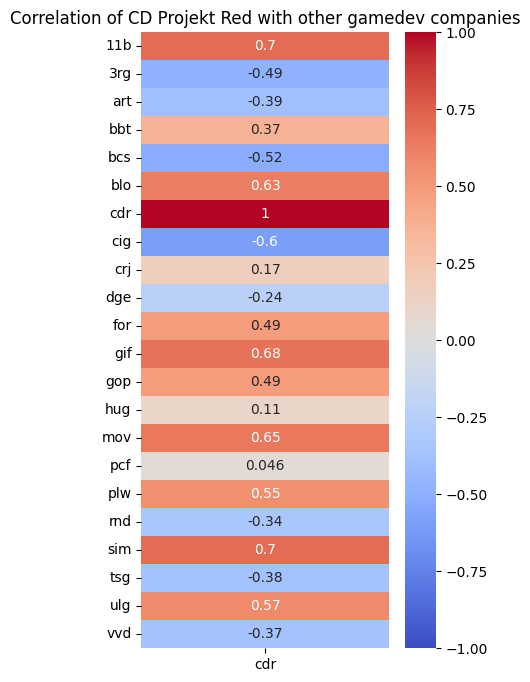

In [9]:
cdr_corr = corr_matrix[['cdr']]

plt.figure(figsize=(4, 8))
sns.heatmap(cdr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of CD Projekt Red with other gamedev companies')
plt.show()

Tu napisać wnioski o tych dwóch mapkach

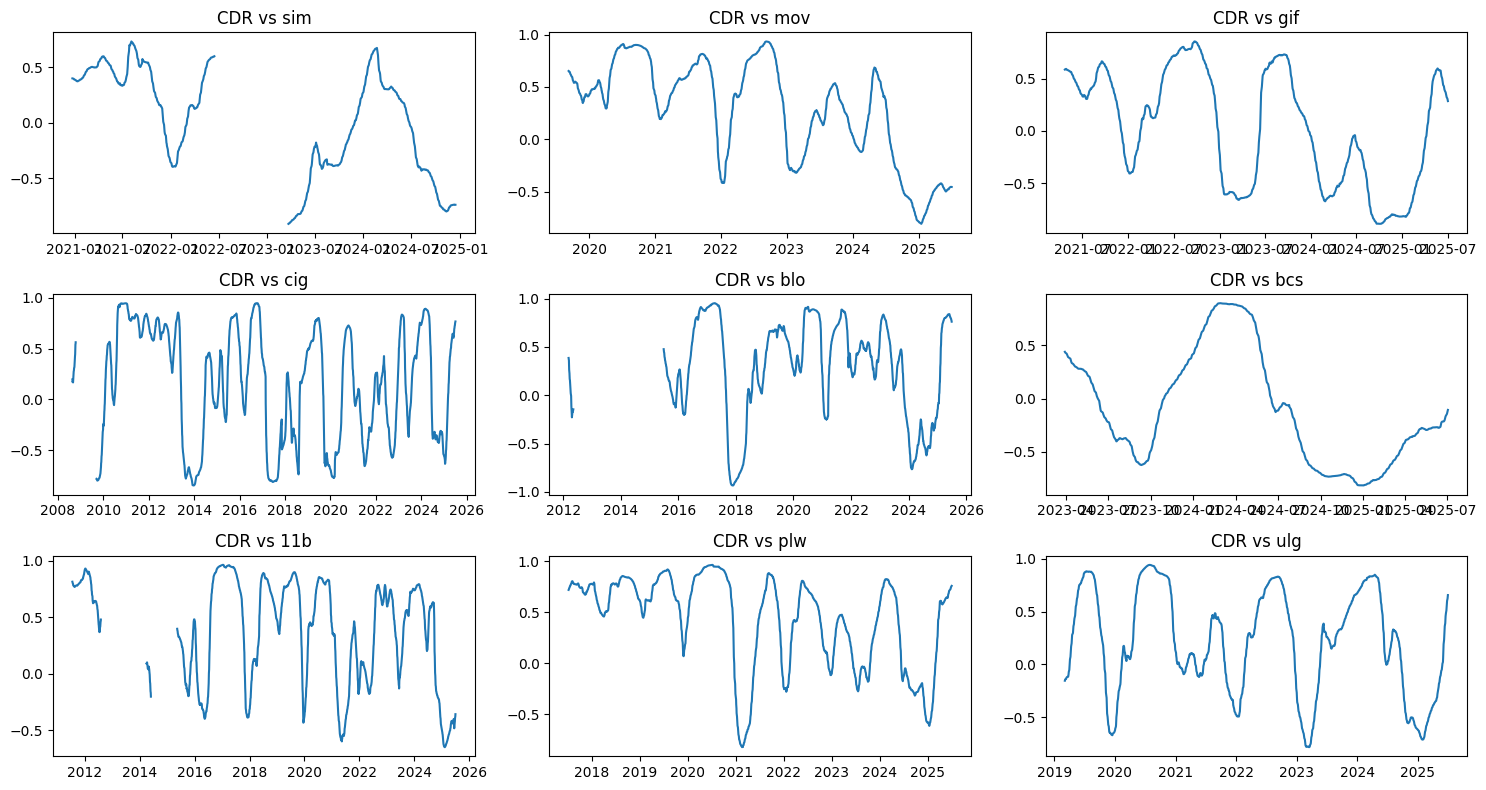

In [13]:
monthly_close = close_prices.resample('ME').last()
rolling_corr = monthly_close['cdr'].rolling(12).corr(monthly_close[ticker])

selected_tickers = ['sim', 'mov', 'gif', 'cig', 'blo', 'bcs', '11b', 'plw', 'ulg']

fig, axs = plt.subplots(3, 3, figsize=(15, 8))

for i, ticker in enumerate(selected_tickers):
    ax = axs[i//3, i%3]
    rolling_corr = close_prices['cdr'].rolling(180).corr(close_prices[ticker])
    ax.plot(rolling_corr)
    ax.set_title(f'CDR vs {ticker}')
plt.tight_layout()
plt.savefig('rollingcorr_cdr_vs_rest')
plt.show()

wnioski

### 4. Optimisation of "Wig-Gry" index weights

In [18]:
from scipy.optimize import minimize

# 1. Stwórz macierz zwrotów
returns = close_prices.pct_change(fill_method=None).dropna()
tickers = returns.columns

# 2. Funkcja ryzyka (wariancja portfela)
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# 3. Warunki
n = len(tickers)
init_weights = np.ones(n) / n  # start = equal weight
bounds = tuple((0, 1) for _ in range(n))  # wagi od 0 do 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# 4. Macierz kowariancji
cov_matrix = returns.cov() * 252  # annualized

# 5. Optymalizacja
opt = minimize(portfolio_volatility, init_weights,
               args=(cov_matrix,),
               method='SLSQP',
               bounds=bounds,
               constraints=constraints)

# 6. Wynik
optimal_weights = opt.x
portfolio_vol = portfolio_volatility(optimal_weights, cov_matrix)

print("Optimal weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"Expected portfolio volatility: {portfolio_vol:.2%}")

Optimal weights:
11b: 4.46%
3rg: 3.19%
art: 2.33%
bbt: 7.56%
bcs: 4.30%
blo: 10.04%
cdr: 4.26%
cig: 1.35%
crj: 6.00%
dge: 1.05%
for: 4.66%
gif: 1.73%
gop: 0.22%
hug: 9.25%
mov: 0.59%
pcf: 2.55%
plw: 4.75%
rnd: 4.43%
sim: 1.85%
tsg: 12.31%
ulg: 8.76%
vvd: 4.37%
Expected portfolio volatility: 16.17%


In [23]:
# 1. Wylicz zwroty i potrzebne macierze
returns = close_prices.pct_change(fill_method=None).dropna()
tickers = returns.columns

mean_returns = returns.mean()
cov_matrix = returns.cov() * 252  # annualized

# 2. Funkcja celu: ujemny Sharpe Ratio (bo minimize minimalizuje)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.03):
    port_return = np.dot(weights, mean_returns) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (port_return - risk_free_rate) / port_vol

# 3. Warunki i ograniczenia
n = len(tickers)
init_weights = np.ones(n) / n
bounds = tuple((0, 1) for _ in range(n))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# 4. Optymalizacja
opt_sharpe = minimize(
    neg_sharpe_ratio,
    init_weights,
    args=(mean_returns, cov_matrix, 0.03),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# 5. Wyniki
optimal_weights_sharpe = opt_sharpe.x
expected_return = np.dot(optimal_weights_sharpe, mean_returns) * 252
portfolio_vol = np.sqrt(np.dot(optimal_weights_sharpe.T, np.dot(cov_matrix, optimal_weights_sharpe)))
sharpe_ratio = (expected_return - 0.03) / portfolio_vol

print("Optimal weights for max Sharpe Ratio:")
for ticker, weight in zip(tickers, optimal_weights_sharpe):
    print(f"{ticker}: {weight:.2%}")

print(f"\nExpected annual return: {expected_return:.2%}")
print(f"Expected portfolio volatility: {portfolio_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Optimal weights for max Sharpe Ratio:
11b: 0.00%
3rg: 0.00%
art: 34.10%
bbt: 0.00%
bcs: 0.00%
blo: 21.95%
cdr: 0.00%
cig: 0.00%
crj: 0.00%
dge: 0.00%
for: 0.00%
gif: 24.37%
gop: 13.93%
hug: 0.00%
mov: 0.00%
pcf: 0.00%
plw: 0.00%
rnd: 5.66%
sim: 0.00%
tsg: 0.00%
ulg: 0.00%
vvd: 0.00%

Expected annual return: 30.14%
Expected portfolio volatility: 28.97%
Sharpe Ratio: 0.94


### 5. Analysis of events

### 6. Conclusions

### *7.Possible extension in the future

- Sentiment analysis
- Comparison of trading volumes
- Event-driven testing strategy